# Disambiguation

In [2]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings

In [3]:
epsilon = 10e-20

In [4]:
def produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r, mixed_start=False, contiguous=True):
    
    n_r = int(r * n_patterns/2)
    n_s = int(s * hypercolumns)
    n_size = int(n_patterns / 2)

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    sequence1 = matrix[:n_size]
    sequence2 = matrix[n_size:]
 
    if mixed_start:
        start_index = 0
        end_index = n_r 
    else:
        start_index = max(int(0.5 * (n_size - n_r)), 0)
        end_index = min(start_index + n_r, n_size)
    
    for index in range(start_index, end_index):
        if contiguous:
            sequence2[index, :n_s] = sequence1[index, :n_s]
        else:
            sequence2[index, ...] = sequence1[index, ...]
            sequence2[index, n_s:] = n_patterns + index 
        
    if False:
        print(n_r)
        print(n_size)
        print(start_index)
        print(end_index)
           
    return sequence1, sequence2

def create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                     training_time, inter_pulse_interval, inter_sequence_interval, 
                                      epochs, resting_time):
    filtered = True
    minicolumns = nn.minicolumns
    hypercolumns = nn.hypercolumns
       
    tau_z_pre_ampa = nn.tau_z_pre_ampa
    tau_z_post_ampa = nn.tau_z_post_ampa
    
    seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r, 
                                             mixed_start=mixed_start, contiguous=contiguous)

    nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
    nr2 = build_network_representation(seq2, minicolumns, hypercolumns)

    # Get the first
    timed_input = TimedInput(nr1, dt, training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_pulse_interval, epochs=epochs, 
                             resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)


    pi1, pj1, P1 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
    w_timed1 = get_weights_from_probabilities(pi1, pj1, P1, minicolumns, hypercolumns)
    t1 = timed_input.T_total

    # Get the second
    timed_input = TimedInput(nr2, dt, training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_pulse_interval, epochs=epochs,
                             resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)
    t2 = timed_input.T_total

    pi2, pj2, P2 = timed_input.calculate_probabilities_from_time_signal(filtered=filtered)
    w_timed2 = get_weights_from_probabilities(pi2, pj2, P2, minicolumns, hypercolumns)
    t_total = t1 + t2

    # Mix
    pi_total = (t1 / t_total) * pi1 + ((t_total - t1)/ t_total) * pi2
    pj_total = (t1 / t_total) * pj1 + ((t_total - t1)/ t_total) * pj2
    P_total = (t1 / t_total) * P1 + ((t_total - t1)/ t_total) * P2
    w_total, beta = get_weights_from_probabilities(pi_total, pj_total, P_total, minicolumns, hypercolumns)
    
    return seq1, seq2, nr1, nr2, w_total, beta

def calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=False, remove=0.020):
    n_seq = nr.shape[0] 
    I_cue = nr[0]
  
    # Do the recall
    manager.run_network_recall(T_recall=T_recall, I_cue=I_cue, T_cue=T_cue,
                           reset=True, empty_history=True)
    distances = calculate_angle_from_history(manager)
    winning = calculate_winning_pattern_from_distances(distances)
    timings = calculate_patterns_timings(winning, manager.dt, remove=remove)
    pattern_sequence = [x[0] for x in timings]
    # Calculate whether it was succesfull 
    success = 1.0
    for index, pattern_index in enumerate(pattern_sequence[:n_seq]):
        pattern = manager.patterns_dic[pattern_index]
        goal_pattern = nr[index]

        if not np.array_equal(pattern, goal_pattern):
 
            success = 0.0
            break
    if debug:
        return success, timings, pattern_sequence
    else:
        return success 


## An example

s1= 1.0
s2= 1.0


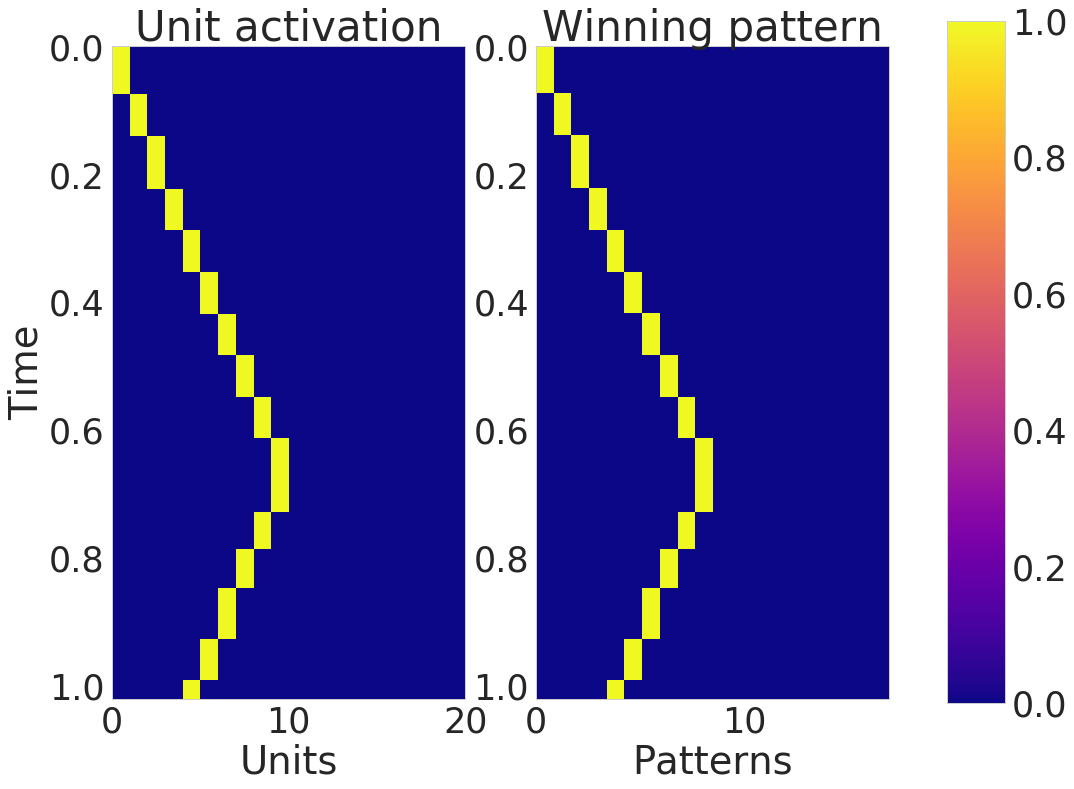

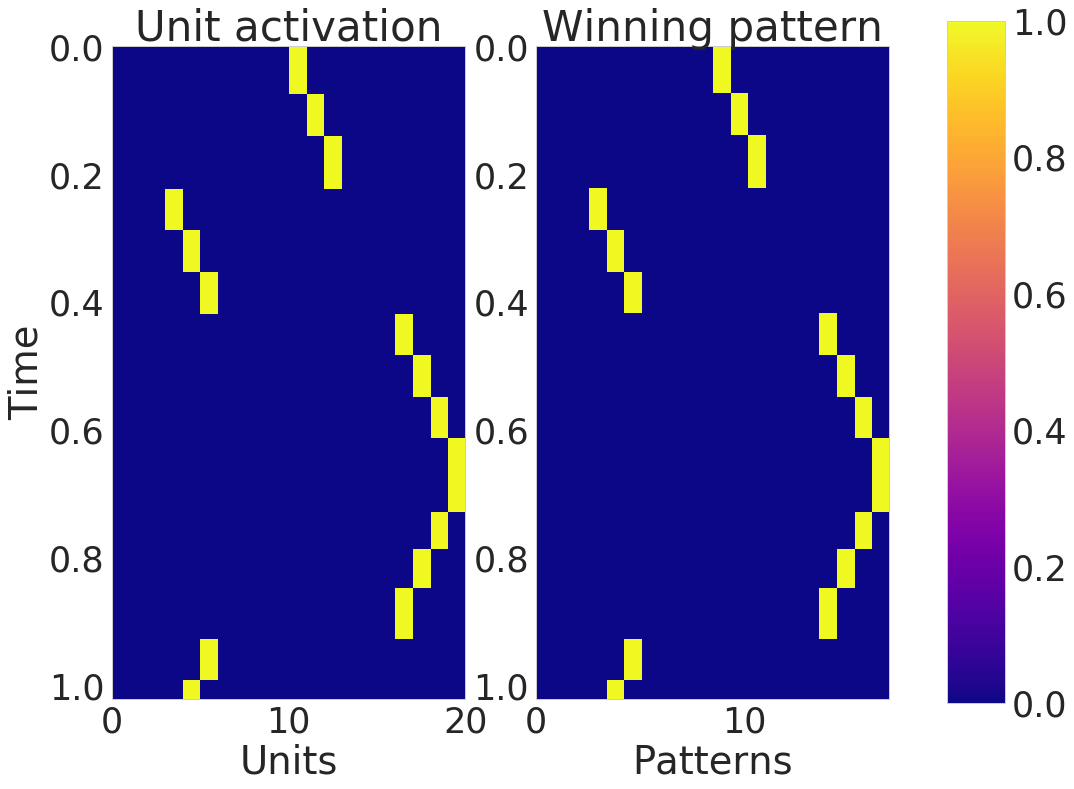

In [5]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 1.0
T_cue = 0.020

# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
mixed_start = False
contiguous = True
s = 1.0
r = 0.3
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs,
                                        resting_time=resting_time) 

seq1, seq2, nr1, nr2, w_total, beta = aux

nr = np.concatenate((nr1, nr2))
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}


nn.w_ampa = w_total
manager.patterns_dic = patterns_dic


s = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
print('s1=', s)
plot_network_activity_angle(manager)
s = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
print('s2=', s)
plot_network_activity_angle(manager)

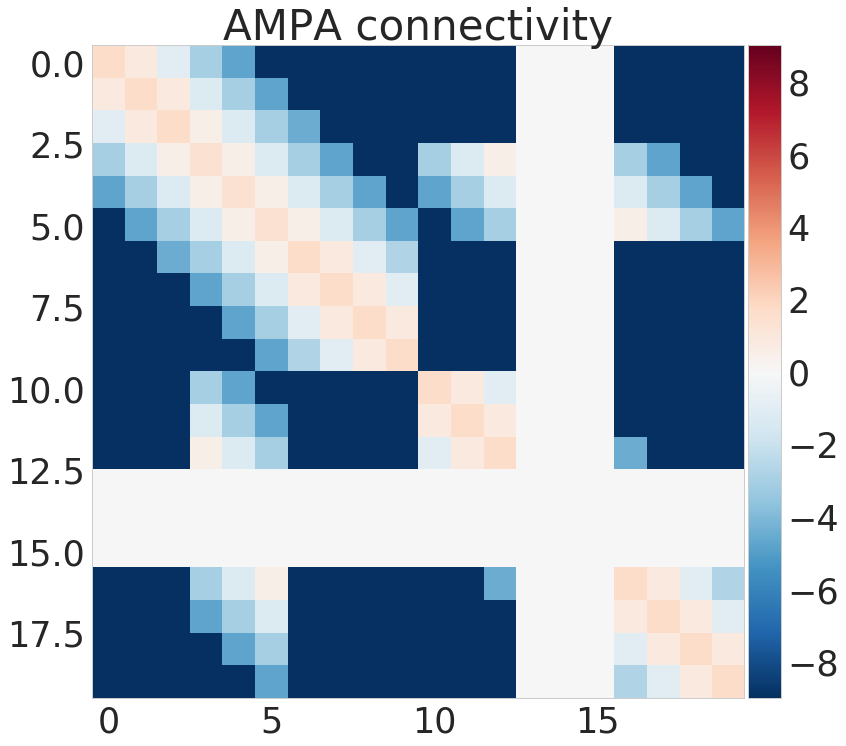

In [6]:
plot_weight_matrix(nn, ampa=True)

## Currents

s1= 1.0


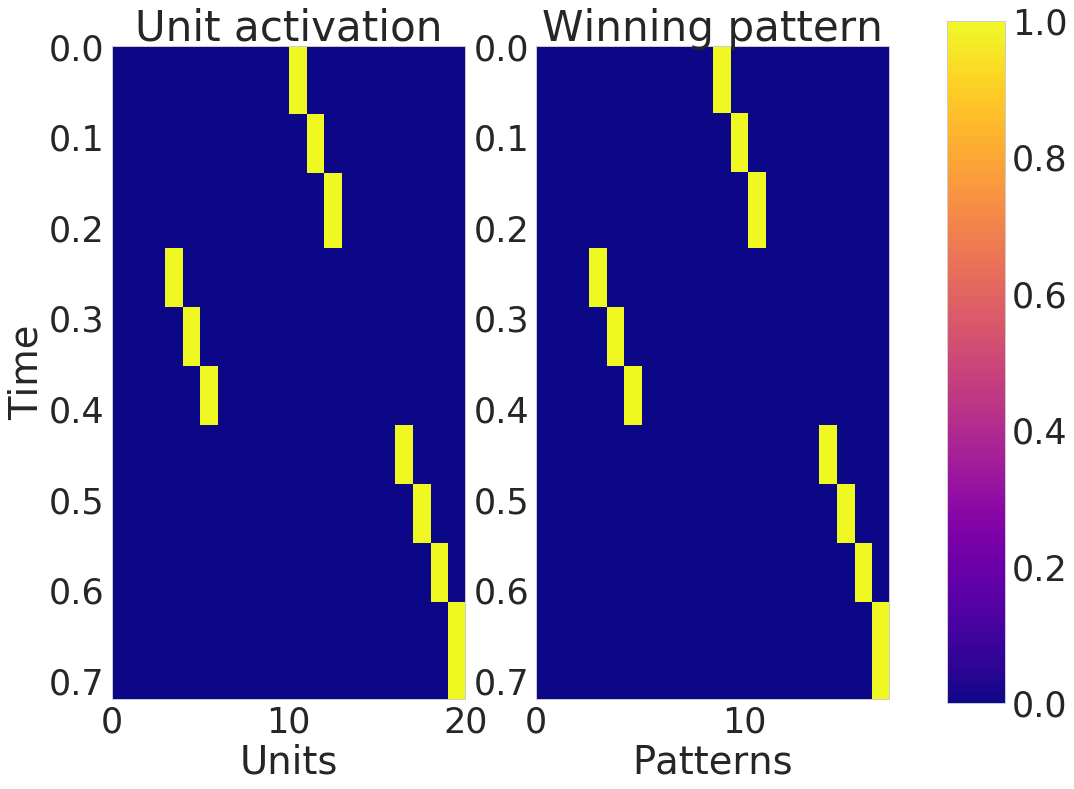

In [63]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 0.70
T_cue = 0.020

# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
mixed_start = False
contiguous = True
s = 1.0
r = 0.3
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs,
                                        resting_time=resting_time) 

seq1, seq2, nr1, nr2, w_total, beta = aux

nr = np.concatenate((nr1, nr2))
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}


nn.w_ampa = w_total
manager.patterns_dic = patterns_dic
s = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
print('s1=', s)
plot_network_activity_angle(manager)

In [64]:
o = manager.history['o']
s = manager.history['s']
i_ampa = manager.history['i_ampa']

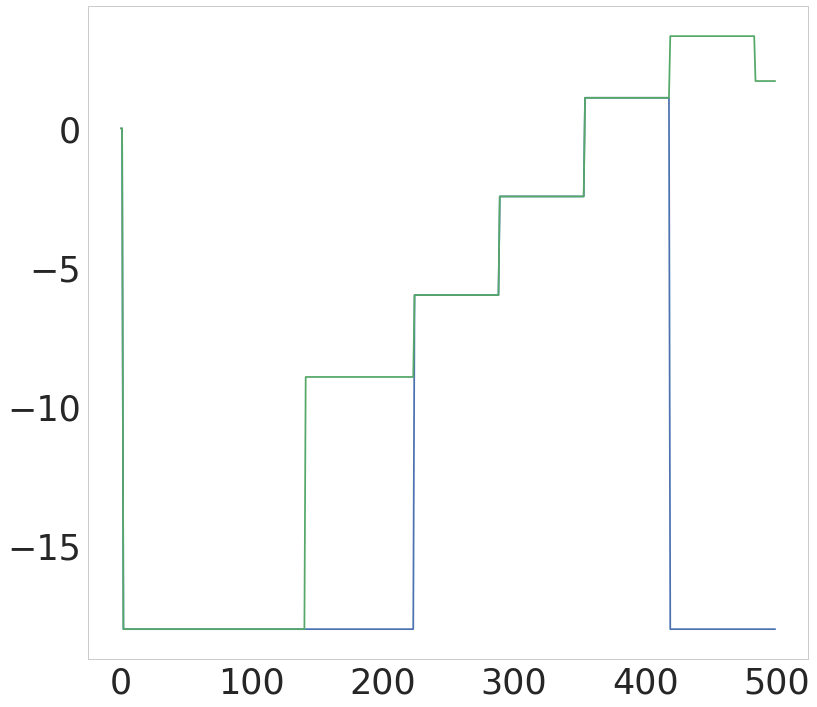

In [65]:
low_limit = 000
high_limit = 500

plt.plot(i_ampa[low_limit:high_limit, 6])
plt.plot(i_ampa[low_limit:high_limit, 16])

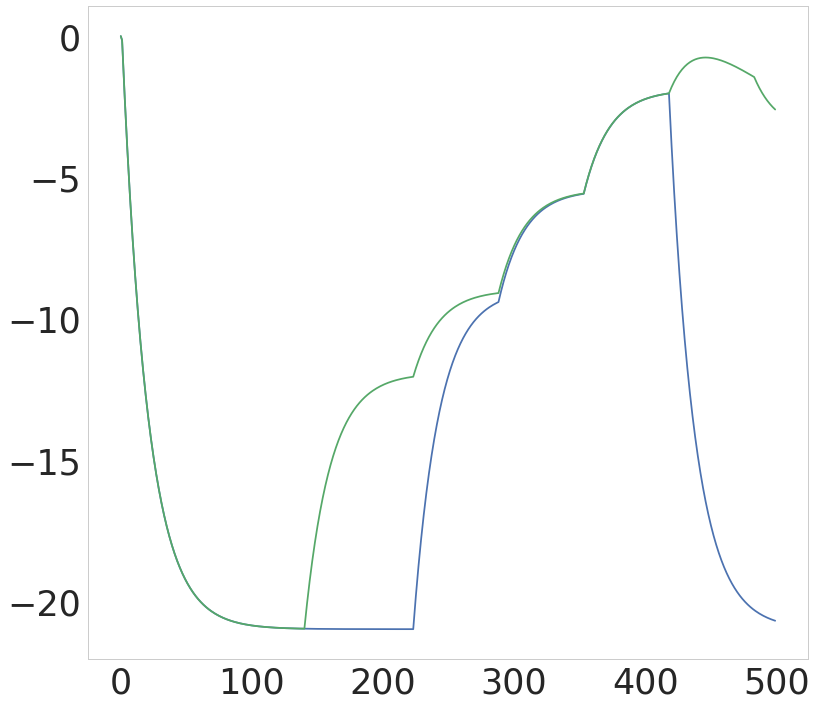

In [66]:
plt.plot(s[low_limit:high_limit, 6])
plt.plot(s[low_limit:high_limit, 16]);

In [68]:
print(w_total[16, 5])
print(w_total[6, 5])

0.550153251377
0.550153251377


In [69]:
print(w_total[16, 4])
print(w_total[6, 4])

-1.22272344467
-1.22272344467


In [70]:
print(w_total[16, 3])
print(w_total[6, 3])

-2.99560014071
-2.99560014071


In [72]:
print(w_total[16, 12])
print(w_total[6, 2])

-4.46744684109
-4.46744684109


In [53]:
seq2

array([[10],
       [11],
       [12],
       [ 3],
       [ 4],
       [ 5],
       [16],
       [17],
       [18],
       [19]])

## More systematic

In [6]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
s = 1.0
r = 0.25

# Recall
T_recall = 1.0
T_cue = 0.020

num = 10
r_space = np.linspace(0, 0.9, num=num)
success_vector = np.zeros(num)


for r_index, r in enumerate(r_space):
    print(r_index)
    # The network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # The sequences
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs,
                                        resting_time=resting_time) 
    seq1, seq2, nr1, nr2, w_total, beta = aux
    nr = np.concatenate((nr1, nr2))
    aux, indexes = np.unique(nr, axis=0, return_index=True)
    patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
    nn.w_ampa = w_total
    manager.patterns_dic = patterns_dic

    # Recall
    s1 = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
    s2 = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
    success_vector[r_index] = 0.5 * (s1 + s2)

0
1
2
3
4
5
6
7
8
9
CPU times: user 6.78 s, sys: 32 ms, total: 6.82 s
Wall time: 6.8 s


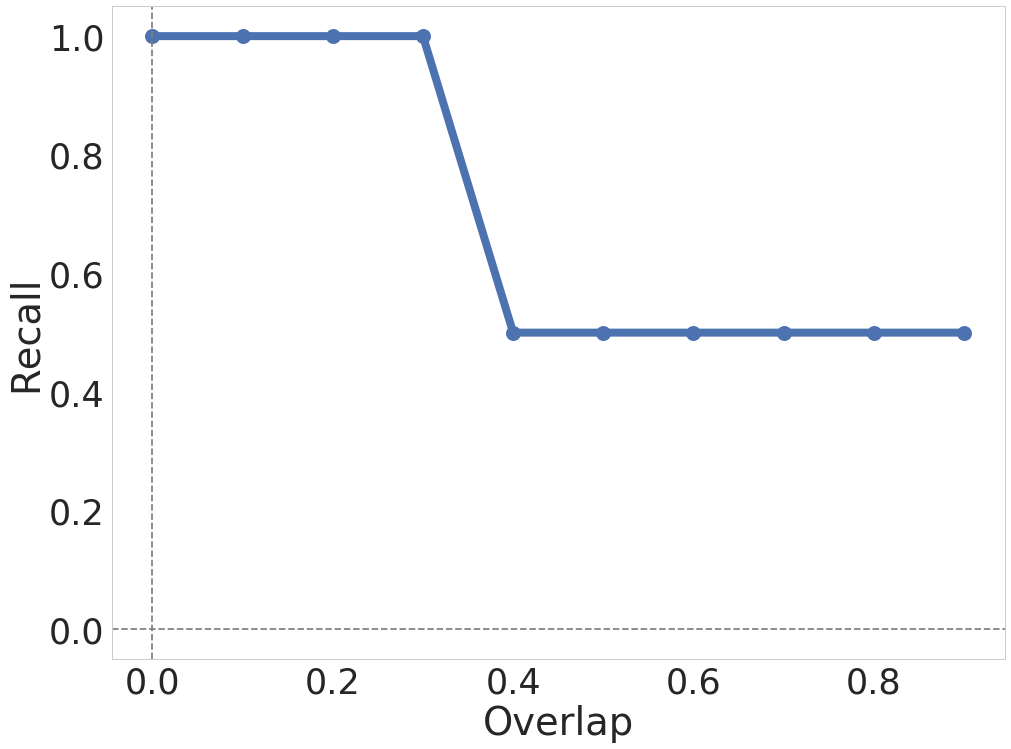

In [7]:
markersize = 15
linewdith = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(r_space, success_vector, 'o-', lw=linewdith, ms=markersize)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')

#### tau_z

In [8]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
s = 1.0
r = 0.25

# Recall
T_recall = 1.0
T_cue = 0.020

num = 10
r_space = np.linspace(0, 0.9, num=num)
success_vector = np.zeros(num)

tau_z_list = [0.025, 0.035, 0.050, 0.075]
#tau_z_list = [0.025, 0.100, 0.250]
#tau_z_list = [0.025, 0.050]


success_list = []


for tau_z_pre_ampa in tau_z_list:
    success_vector = np.zeros(num)
    print(tau_z_pre_ampa)
    for r_index, r in enumerate(r_space):
        # The network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)


        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # The sequences
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs,
                                        resting_time=resting_time) 
        seq1, seq2, nr1, nr2, w_total, beta = aux
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        nn.w_ampa = w_total
        manager.patterns_dic = patterns_dic

        # Recall
        s1 = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
        s2 = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
        success_vector[r_index] = 0.5 * (s1 + s2)
        
    success_list.append(np.copy(success_vector))

0.025
0.035
0.05
0.075
CPU times: user 27.1 s, sys: 32 ms, total: 27.1 s
Wall time: 27.1 s


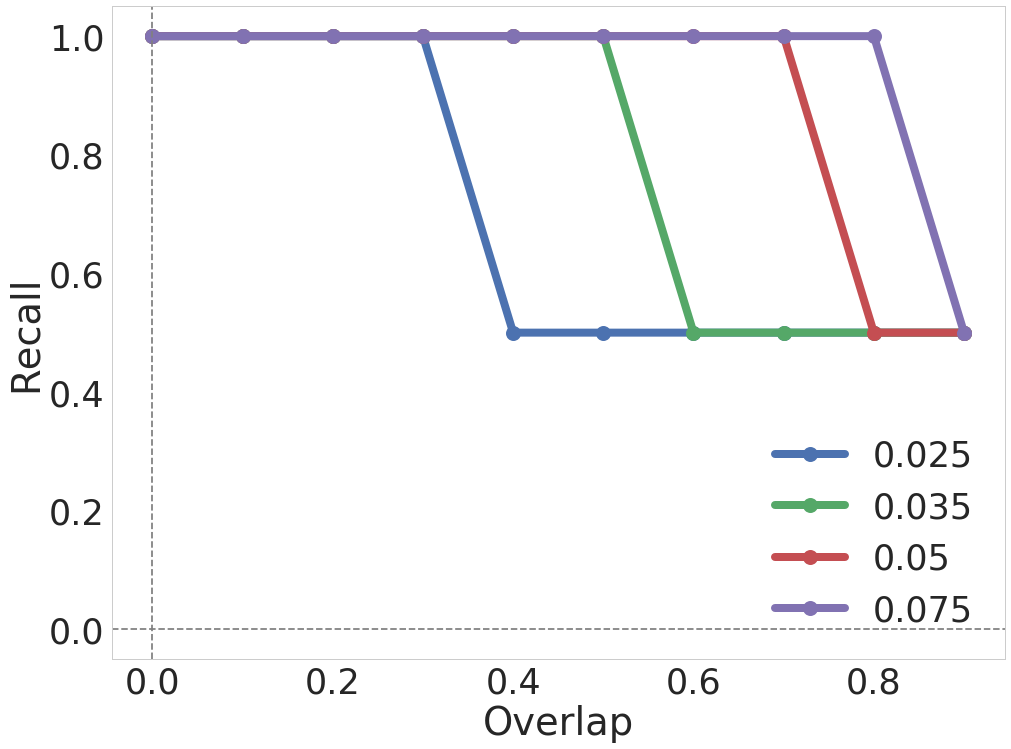

In [9]:
markersize = 15
linewdith = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for tau_z, success_vector in zip(tau_z_list, success_list):
    ax.plot(r_space, success_vector, 'o-', lw=linewdith, ms=markersize, label=str(tau_z))

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')

ax.legend();

#### Scale

In [10]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
s = 1.0
r = 0.25

# Recall
T_recall = 1.0
T_cue = 0.020

num = 10
r_space = np.linspace(0, 0.9, num=num)
success_vector = np.zeros(num)

hypercolumns_list = [1, 3, 7, 10]
#tau_z_list = [0.025, 0.100, 0.250]
#tau_z_list = [0.025, 0.050]


success_list = []


for hypercolumns in hypercolumns_list:
    success_vector = np.zeros(num)
    print(hypercolumns)
    for r_index, r in enumerate(r_space):
        # The network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)


        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # The sequences
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs,
                                        resting_time=resting_time) 
        seq1, seq2, nr1, nr2, w_total, beta = aux
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        nn.w_ampa = w_total
        manager.patterns_dic = patterns_dic

        # Recall
        s1 = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
        s2 = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
        success_vector[r_index] = 0.5 * (s1 + s2)
        
    success_list.append(np.copy(success_vector))

1
3
7
10
CPU times: user 7min 16s, sys: 56.3 s, total: 8min 13s
Wall time: 3min 23s


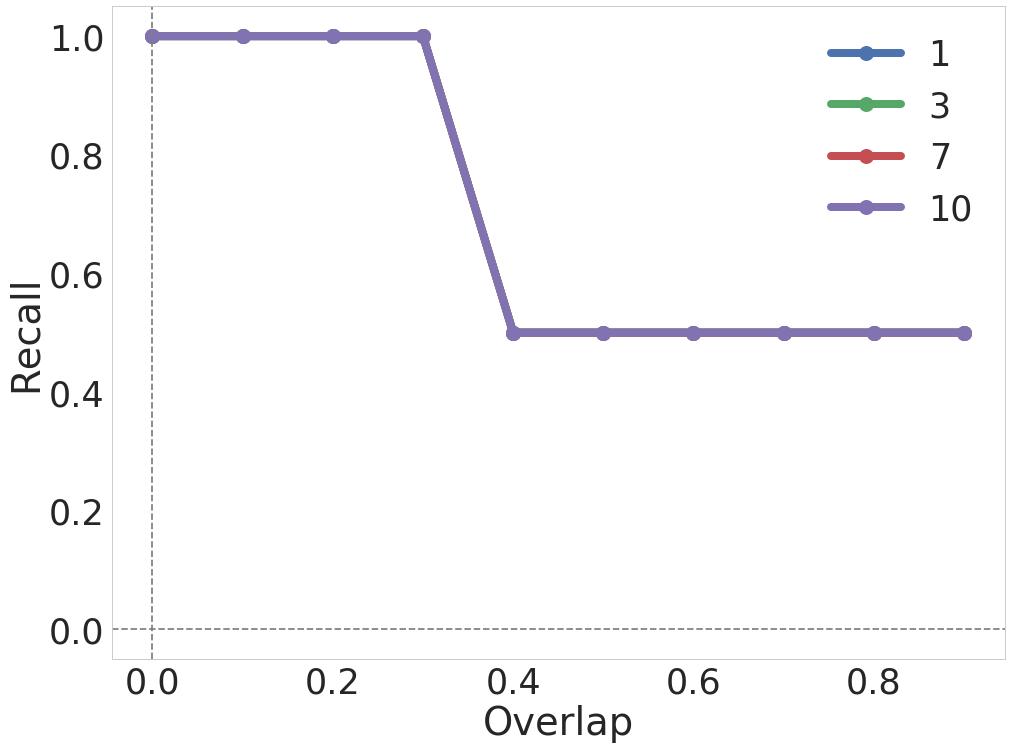

In [11]:
markersize = 15
linewdith = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for hypercolumns, success_vector in zip(hypercolumns_list, success_list):
    ax.plot(r_space, success_vector, 'o-', lw=linewdith, ms=markersize, label=str(hypercolumns))

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')

ax.legend();

#### tau_m

In [12]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
s = 1.0
r = 0.25

# Recall
T_recall = 1.0
T_cue = 0.020

num = 10
r_space = np.linspace(0, 0.9, num=num)
success_vector = np.zeros(num)

tau_m_list = [0.001, 0.008, 0.020]
 
success_list = []


for tau_m in tau_m_list:
    success_vector = np.zeros(num)
    print(tau_m)
    for r_index, r in enumerate(r_space):
        # The network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)


        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # The sequences
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs,
                                        resting_time=resting_time) 
        seq1, seq2, nr1, nr2, w_total, beta = aux
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        nn.w_ampa = w_total
        manager.patterns_dic = patterns_dic

        # Recall
        s1 = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
        s2 = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
        success_vector[r_index] = 0.5 * (s1 + s2)
        
    success_list.append(np.copy(success_vector))

0.001
0.008
0.02
CPU times: user 20.4 s, sys: 32 ms, total: 20.4 s
Wall time: 20.4 s


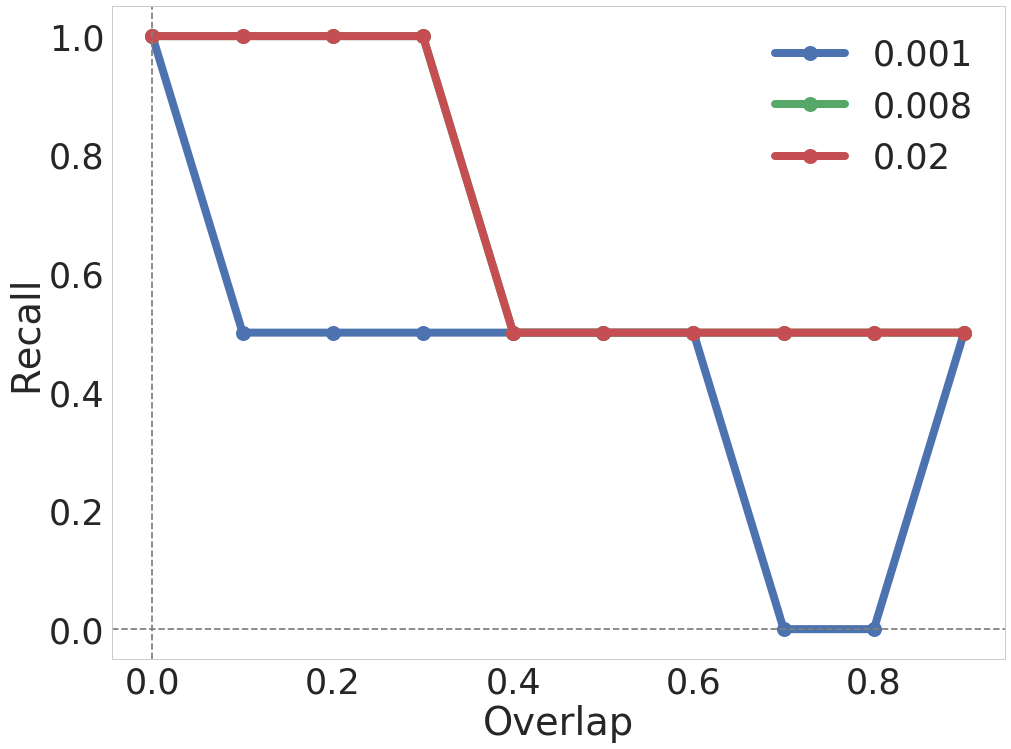

In [13]:
markersize = 15
linewdith = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for tau_m, success_vector in zip(tau_m_list, success_list):
    ax.plot(r_space, success_vector, 'o-', lw=linewdith, ms=markersize, label=str(tau_m))

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')

ax.legend();

#### training time

In [14]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
s = 1.0
r = 0.25

# Recall
T_recall = 1.0
T_cue = 0.020

num = 10
r_space = np.linspace(0, 0.9, num=num)
success_vector = np.zeros(num)

training_time_list = [0.050, 0.100, 0.250, 0.500]

success_list = []


for training_time in training_time_list:
    success_vector = np.zeros(num)
    print(training_time)
    for r_index, r in enumerate(r_space):
        # The network
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)


        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        # The sequences
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
        aux = create_weights_from_two_sequences(nn, dt, n_patterns, s, r, mixed_start, contiguous, 
                                        training_time, inter_pulse_interval=inter_pulse_interval,
                                        inter_sequence_interval=inter_sequence_interval, epochs=epochs,
                                        resting_time=resting_time) 
        seq1, seq2, nr1, nr2, w_total, beta = aux
        nr = np.concatenate((nr1, nr2))
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        nn.w_ampa = w_total
        manager.patterns_dic = patterns_dic

        # Recall
        s1 = calculate_recall_success_nr(manager, nr1, T_recall, T_cue)
        s2 = calculate_recall_success_nr(manager, nr2, T_recall, T_cue)
        success_vector[r_index] = 0.5 * (s1 + s2)
        
    success_list.append(np.copy(success_vector))

0.05
0.1
0.25
0.5
CPU times: user 29.2 s, sys: 268 ms, total: 29.4 s
Wall time: 29.4 s


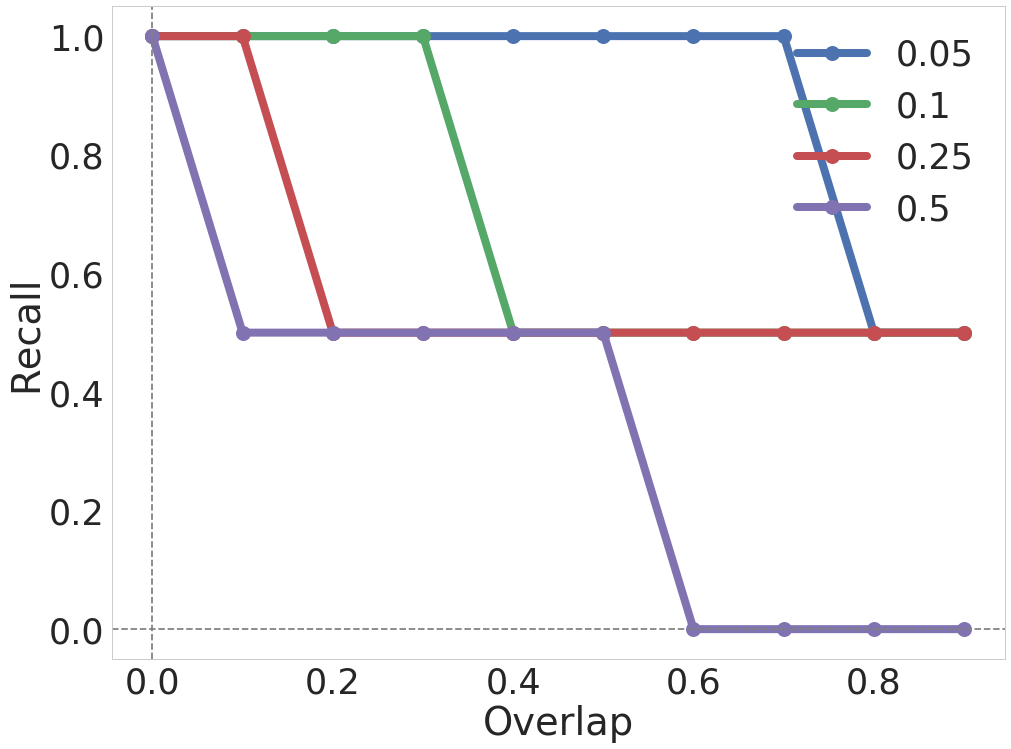

In [15]:
markersize = 15
linewdith = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for training_time, success_vector in zip(training_time_list, success_list):
    ax.plot(r_space, success_vector, 'o-', lw=linewdith, ms=markersize, label=str(training_time))

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_xlabel('Overlap')
ax.set_ylabel('Recall')

ax.legend();